In [1]:
# Import dependencies
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Read in CSV and check columns
df=pd.read_csv('Resources/clean_test.csv')
for column in df.columns:
    print(column)

Beer_Style
Beer_Name_Full
ABV
Min_IBU
Max_IBU
Astringency
Body
Alcohol
Bitter
Sweet
Sour
Salty
Fruits
Hoppy
Spices
Malty
review_aroma
review_appearance
review_palate
review_taste
review_overall
number_of_reviews


In [3]:
df=df.drop(['Beer_Style','Beer_Name_Full','review_aroma','review_appearance','review_palate','review_taste','number_of_reviews'], axis = 1)

In [4]:
# Defining reviews for successful beers (greater than or equal to a rating of 4)
df["review_overall"].loc[df["review_overall"] <4] = 0
df["review_overall"].loc[df["review_overall"] >=4] = 1

C:\Users\saman\anaconda3\envs\mlenv\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [5]:
# Define X and Y variables
X=df.drop('review_overall',axis=1)
y=df['review_overall'] 

In [6]:
# Split data into training and testing / Scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Create random forest classifier / fit model
clf = RandomForestClassifier(random_state=1, n_estimators=500).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 0.74125


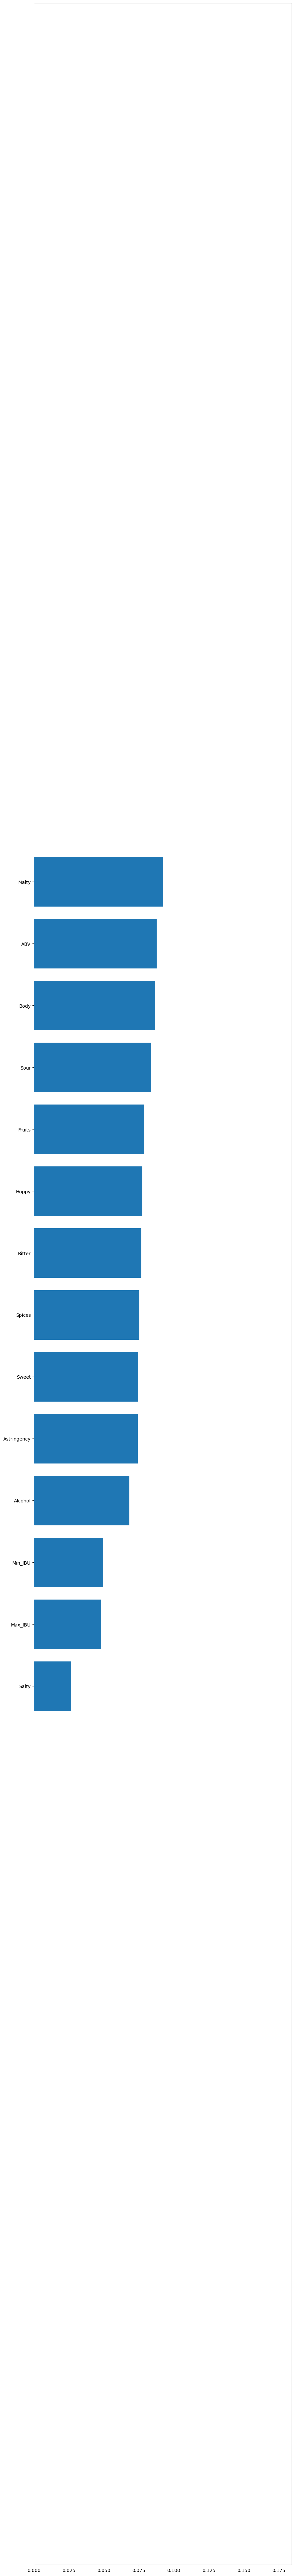

In [8]:
# Plot features in order of importance
features = sorted(zip(X.columns, clf.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(10,100)
plt.margins(1,1)
    
ax.barh(y=cols, width=width)

plt.show()

In [9]:
# Feature selection
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(clf)
sel.fit(X_train_scaled, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=500,
                                                 random_state=1))

In [10]:
# Train/test split on selected features 
X_selected_train, X_selected_test, y_train, y_test = train_test_split(sel.transform(X), y, random_state=1)
scaler = StandardScaler().fit(X_selected_train)
X_selected_train_scaled = scaler.transform(X_selected_train)
X_selected_test_scaled = scaler.transform(X_selected_test)

C:\Users\saman\anaconda3\envs\mlenv\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [13]:
# Fitting the model and determining the score
clf = LogisticRegression().fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

Training Score: 0.7321652065081352
Testing Score: 0.73625


In [14]:
# Fitting the model and determining the score
clf = LogisticRegression().fit(X_selected_train_scaled, y_train)
print(f'Training Score: {clf.score(X_selected_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_selected_test_scaled, y_test)}')

Training Score: 0.7325823946599916
Testing Score: 0.73
